# Import 

In [347]:
# Data structure libraries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Visualization libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [438]:
sleep_data = pd.read_csv('./data/Archive/processed_data.csv')

# Data Preprocessing

In [439]:
def normalize_feature(feature_to_normalize, max_val, min_val) :
    feature_length = len(feature_to_normalize)
    normalized = []
    for i in range(feature_length) :
        normalized.append(((feature_to_normalize[i] - min_val) / (max_val - min_val))[0])
    return normalized

In [440]:
# Removing unnamed column
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('^Unnamed')]

In [441]:
# Removing SEQN
sleep_data = sleep_data.loc[:, ~sleep_data.columns.str.contains('SEQN')]

In [442]:
# Adding in columns to the dataframe
sleep_data.columns =[['RIAGENDR', 'RIDAGEYR', 'SLQ040', 'SLQ050', 'PAQ605', 'PAQ620', 'SMQ040', 
                      'ALQ130', 'DIQ010', 'BMXBMI', 'physical_activity', 'smoking', 'alcohol', 'diabetes',
                      'DR1IMAGN', 'DR1IIRON', 'DR1ISFAT', 'DR1IPFAT', 'DR1IMFAT', 
                      'DR2IMAGN', 'DR2IIRON', 'DR2ISFAT', 'DR2IPFAT', 'DR2IMFAT','sleep_disorder']]

# Normalize data
maxList = sleep_data.max()
minList = sleep_data.min()

# Lists that store the normalized values
RIAGENDR_norm = normalize_feature(sleep_data['RIAGENDR'].values.tolist(), maxList[0], minList[0])
RIDAGEYR_norm = normalize_feature(sleep_data['RIDAGEYR'].values.tolist(), maxList[1], minList[1])
SLQ040_norm = normalize_feature(sleep_data['SLQ040'].values.tolist(), maxList[2], minList[2])
SLQ050_norm = normalize_feature(sleep_data['SLQ050'].values.tolist(), maxList[3], minList[3])

PAQ605_norm = normalize_feature(sleep_data['PAQ605'].values.tolist(), maxList[4], minList[4])
PAQ620_norm = normalize_feature(sleep_data['PAQ620'].values.tolist(), maxList[5], minList[5])
SMQ040_norm = normalize_feature(sleep_data['SMQ040'].values.tolist(), maxList[6], minList[6])
ALQ130_norm = normalize_feature(sleep_data['ALQ130'].values.tolist(), maxList[7], minList[7])

DIQ010_norm = normalize_feature(sleep_data['DIQ010'].values.tolist(), maxList[8], minList[8])
BMXBMI_norm = normalize_feature(sleep_data['BMXBMI'].values.tolist(), maxList[9], minList[9])
physical_activity_norm = normalize_feature(sleep_data['physical_activity'].values.tolist(), maxList[10], minList[10])
smoking_norm = normalize_feature(sleep_data['smoking'].values.tolist(), maxList[11], minList[11])

alcohol_norm = normalize_feature(sleep_data['alcohol'].values.tolist(), maxList[12], minList[12])
diabetes_norm = normalize_feature(sleep_data['diabetes'].values.tolist(), maxList[13], minList[13])
DR1IMAGN_norm = normalize_feature(sleep_data['DR1IMAGN'].values.tolist(), maxList[14], minList[14])
DR1IIRON_norm = normalize_feature(sleep_data['DR1IIRON'].values.tolist(), maxList[15], minList[15])

DR1ISFAT_norm = normalize_feature(sleep_data['DR1ISFAT'].values.tolist(), maxList[16], minList[16])
DR1IPFAT_norm = normalize_feature(sleep_data['DR1IPFAT'].values.tolist(), maxList[17], minList[17])
DR1IMFAT_norm = normalize_feature(sleep_data['DR1IMFAT'].values.tolist(), maxList[18], minList[18])
DR2IMAGN_norm = normalize_feature(sleep_data['DR2IMAGN'].values.tolist(), maxList[19], minList[19])

DR2IIRON_norm = normalize_feature(sleep_data['DR2IIRON'].values.tolist(), maxList[20], minList[20])
DR2ISFAT_norm = normalize_feature(sleep_data['DR2ISFAT'].values.tolist(), maxList[21], minList[21])
DR2IPFAT_norm = normalize_feature(sleep_data['DR2IPFAT'].values.tolist(), maxList[22], minList[22])
DR2IMFAT_norm = normalize_feature(sleep_data['DR2IMFAT'].values.tolist(), maxList[23], minList[23])

sleep_disorder_norm = normalize_feature(sleep_data['sleep_disorder'].values.tolist(), maxList[24], minList[24])

# Create a new dataframe with the normalized values
normalized_features = {
         'RIAGENDR': RIAGENDR_norm,
         'RIDAGEYR': RIDAGEYR_norm, 
         'SLQ040': SLQ040_norm,
         'SLQ050': SLQ050_norm,
         'PAQ605': PAQ605_norm,
         'PAQ620': PAQ620_norm, 
         'SMQ040': SMQ040_norm,
         'ALQ130': ALQ130_norm,
         'DIQ010': DIQ010_norm,
         'BMXBMI': BMXBMI_norm,
         'physical_activity': physical_activity_norm, 
         'smoking': smoking_norm,
         'alcohol': alcohol_norm,
         'diabetes': diabetes_norm,
         'DR1IMAGN': DR1IMAGN_norm,
         'DR1IIRON': DR1IIRON_norm, 
         'DR1ISFAT': DR1ISFAT_norm,
         'DR1IPFAT': DR1IPFAT_norm,
         'DR1IMFAT': DR1IMFAT_norm,
         'DR2IMAGN': DR2IMAGN_norm,
         'DR2IIRON': DR2IIRON_norm, 
         'DR2ISFAT': DR2ISFAT_norm,
         'DR2IPFAT': DR2IPFAT_norm,
         'DR2IMFAT': DR2IMFAT_norm,
         'sleep_disorder': sleep_disorder_norm}

In [443]:
# Convert dictionary into dataframe
norm_df = pd.DataFrame.from_dict(normalized_features)

In [444]:
# Drop columns that may be troublesome
norm_df = norm_df.drop(columns=['RIAGENDR', 'SLQ040', 'SLQ050', 'PAQ605', 'PAQ620', 'SMQ040', 'ALQ130', 'DIQ010',
                                'physical_activity', 'diabetes'])

In [445]:
print(len(norm_df[norm_df['sleep_disorder'] == 1.0]))

375


In [446]:
print(norm_df.head(1))

   RIDAGEYR    BMXBMI   smoking   alcohol  DR1IMAGN  DR1IIRON  DR1ISFAT  \
0  0.709677  0.220564  0.057587  0.090432  0.140802  0.050895  0.079342   

   DR1IPFAT  DR1IMFAT  DR2IMAGN  DR2IIRON  DR2ISFAT  DR2IPFAT  DR2IMFAT  \
0  0.093126  0.150736  0.142495       1.0       1.0       0.0       0.0   

   sleep_disorder  
0             1.0  


# Train - Validation Split

In [447]:
# All feature data
features = norm_df.iloc[:,:-1]
# All label data
labels = norm_df.iloc[:,-1:]

# Using the remaining training records, split into validation, slightly larger split to make it comparable to test size
feature_train, feature_val, label_train, label_val = train_test_split(features, labels, test_size=0.3)

# In the end, we get 3 groups:

# feature_train
# label_train

# feature_test
# label_test

# feature_validation
# label_validation

# Investigating potiential non linear relationships via basis function

In [448]:
# In progress
#poly = PolynomialFeatures(3, include_bias=False)
#poly.fit_transform(feature_val[:, None])

# Hyperparameter Tuning

In [449]:
accuracy_list = []
c_range = np.geomspace(start=0.001, stop=10, num=100)

for c in c_range:
    # Hyperparameter is the number of regularization strength (C), l2 by default
    model = LogisticRegression(solver='liblinear', C=c, random_state=0)
    
    # Learn the model over the training data
    model.fit(feature_train, label_train.values.ravel())

    # Predict labels over the validation data
    model.predict(feature_val)

    # Evaluate accuracy over the validation data
    accuracy_list.append(model.score(feature_val, label_val))

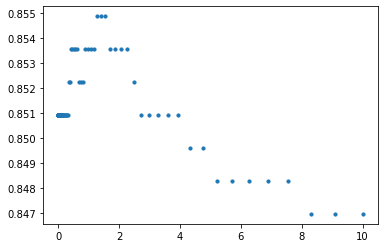

In [450]:
plt.scatter(c_range, accuracy_list, s = 10)
plt.show()

In [451]:
best_accuracy = max(accuracy_list)
best_accuracy_index = accuracy_list.index(best_accuracy)
best_c = c_range[best_accuracy_index]

In [452]:
print('Best Accuracy: ', best_accuracy)
print('Best regularization value', best_c)

Best Accuracy:  0.8548812664907651
Best regularization value 1.291549665014884


# Logistic Regression

In [453]:
feature_train_dump, feature_test, label_train_dump, label_test = train_test_split(feature_train, label_train, test_size=0.3)

In [454]:
# Hyperparameter is the number of regularization strength (C), l2 by default
model = LogisticRegression(solver='liblinear', C=best_c, random_state=0)

# Learn the model over the training data
model.fit(feature_train, label_train.values.ravel())

# Predict labels over the testing data
model.predict(feature_test)

# Evaluate accuracy over the testing data
accuracy = model.score(feature_test, label_test)

# Interpret Results

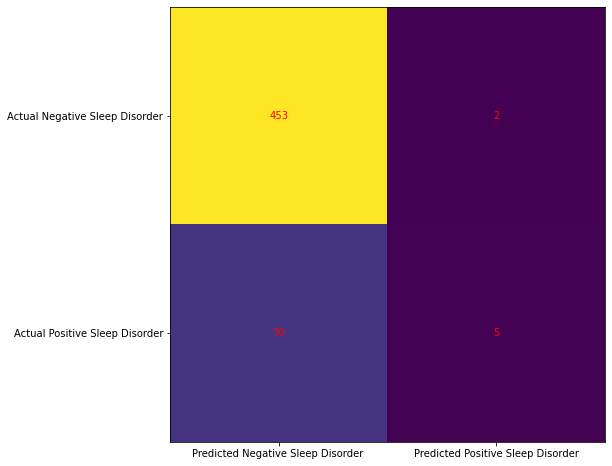

In [455]:
cm = confusion_matrix(label_test, model.predict(feature_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Sleep Disorder ', 'Predicted Positive Sleep Disorder'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative Sleep Disorder', 'Actual Positive Sleep Disorder'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [456]:
print(classification_report(label_test, model.predict(feature_test)))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       455
         1.0       0.71      0.07      0.12        75

    accuracy                           0.86       530
   macro avg       0.79      0.53      0.52       530
weighted avg       0.84      0.86      0.81       530



# Driver (to run entire experiment over k iterations, if needed)